In [1]:
%load_ext autoreload
%autoreload 2

from collections import deque
import csv
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
sys.path.append('../')
from genff.data_handling_old.transform import TranslateToCentroid
from genff.metrics.quant_metrics import CircFitMetric, NotFreeMetric, PersonalSpaceMetric, IntimateSpaceMetric, CenterDistMetric, OccludesOtherMetric, IsOccludedMetric
from genff.opt_method.opt_generator import opt_generator, torch_to_numpy
from genff.visualization import plot_sample

## Utility Functions
for plotting results and comparing CSV files

In [3]:
def compute_loss_for_plotting(loss, min_x=-5.0, max_x=5.0, min_y=-5.0, max_y=5.0):
    X = np.arange(min_x, max_x, 0.1)
    Y = np.arange(min_y, max_y, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = loss((X[i,j], Y[i,j]))
    return X, Y, Z


def plot_test_result(pred_individual, loss, individual, context, mask):
    
    # plot loss
    context_filtered = context[mask.bool(),:]
    if len(context_filtered.shape) < 2:
        context_filtered = torch.unsqueeze(context_filtered, axis=0)
    center = np.mean(context_filtered.numpy(), axis=0)
    X, Y, Z = compute_loss_for_plotting(loss, 
                                        center[0] - 3, center[0] + 3, 
                                        center[1] - 3, center[1] + 3)
    
    fig, ax = plt.subplots(1,1, sharey=True)
    ax.contourf(X, Y, Z, levels=100)
    ax.autoscale(False)
    
    q1 = ax.quiver(context[mask.bool(),0],context[mask.bool(),1],
                   np.cos(context[mask.bool(),2]), np.sin(context[mask.bool(),2]),
                   color="r", label="context")
    
    ax.quiver(individual[0,0],individual[0,1],
              np.cos(individual[0,2]), np.sin(individual[0,2]), 
              linewidths=1, edgecolors='w', color="w", label="true ind")
    
    ax.quiver(pred_individual[:, 0], pred_individual[:, 1],
              np.cos(pred_individual[:, 2]), np.sin(pred_individual[:, 2]), 
              color="g", label="pred ind")

    ax.legend(loc='lower right')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    
    plt.show()
    
    
def compare_results_csv(backup_filename, new_filename, metric):
    metrics_dict = {'CircFit': 3, 'NotFree': 4, 'PerSpace': 5, 'IntSpace': 6, 'CenterDist': 7, 'OccludesOther': 8, 'IsOccluded': 9}
    diff_log = deque()
    
    backup_results = csv.reader(open(backup_filename, 'r'), delimiter=',')
    new_results = csv.reader(open(new_filename, 'r'), delimiter=',')
    for backup_row, new_row in zip(backup_results, new_results):
        if backup_row[1] == new_row[1] and backup_row[metrics_dict[metric]+1] != new_row[metrics_dict[metric]]:
            # print(f'Index: {new_row[1]}, Old {metric}: {backup_row[metrics_dict[metric]+1]}, New {metric}: {new_row[metrics_dict[metric]]}')
            diff_log.append((int(new_row[1]),float(backup_row[metrics_dict[metric]+1]),float(new_row[metrics_dict[metric]])))
    
    return diff_log

## Computing the metrics

These functions just re-implement the metrics already defined in the project, for faster debugging and examination.

In [4]:
def circ_loss_inspect(x, y, center, is_ellipse):
    if is_ellipse:
        pass
    else:
        pass

def env_loss_inspect(x, y, env_map, env_res):
    """
    Environment loss is defined in method env_loss of the class IndividualLoss in genff.opt_method.opt_loss
    """
    offset_x = (env_map.shape[0] * 0.5) * env_res
    offset_y = (env_map.shape[1] * 0.5) * env_res
    
    x = offset_x + x
    y = offset_y + y
    
    c = min(max(int((x / env_res)), 0), env_map.shape[1] - 1)
    r = min(max(int((y / env_res)), 0), env_map.shape[0] - 1)
    
    environment = env_map[:, :, 1]  # free space

    env_value = environment[r,c]

    return (1.0 - env_value)


def perspace_loss_inspect(individual_t, context_t, mask_t, env_t, env_res):
    """
    Personal Space Loss is defined by the class PersonalSpaceMetric, with method compute_metric
    """
    threshold = 0.68
    individual = torch_to_numpy(individual_t.cpu())
    context = torch_to_numpy(context_t.cpu())
    mask = torch_to_numpy(mask_t.cpu())
    
    if mask is not None:
        context = context[mask > 0, :]
    
    ind_pos = individual[:,[0,1]]
    con_pos = context[:,[0,1]]
    diff = np.repeat(ind_pos, con_pos.shape[0], axis=0) - con_pos
    dist = np.linalg.norm(diff, axis=1)
    instances = np.maximum(0, np.full_like(dist, threshold) - dist)
    return np.count_nonzero(instances)


def intimate_loss_inspect(individual_t, context_t, mask_t, env_t, env_res):
    """
    Intimate Space Loss is defined by class IntimateSpaceMetric, with method compute_metric
    It is the same as PersonalSpaceMetric but with a different threshold.
    """
    threshold = 0.42
    individual = torch_to_numpy(individual_t.cpu())
    context = torch_to_numpy(context_t.cpu())
    mask = torch_to_numpy(mask_t.cpu())
    
    if mask is not None:
        context = context[mask > 0, :]
    
    ind_pos = individual[:,[0,1]]
    con_pos = context[:,[0,1]]
    diff = np.repeat(ind_pos, con_pos.shape[0], axis=0) - con_pos
    dist = np.linalg.norm(diff, axis=1)
    instances = np.maximum(0, np.full_like(dist, threshold) - dist)
    return np.count_nonzero(instances)

In [5]:
x = np.arange(-5, 5, 1.0)
y = np.arange(-5, 5, 1.0)
xv, yv = np.meshgrid(x, y)
x0 = np.stack((xv.flatten(),yv.flatten()), axis=1)


def new_data_handling(dataset, idx, draw_result=False):
    individual, context, mask, env = dataset[idx] # sample 404 seems to be problematic
    
    if draw_result:
        plot_sample(individual, context, mask, env, dataset.resolution)
        plt.show()

    pred_individual, final_losses, loss = opt_generator(context, mask, emap=env, eres=dataset.resolution,
                                                        x0=x0,
                                                        ospace_dist=0.72, weight_psloss=0.5, weight_closs=0.8, 
                                                        weight_eloss=0.25, verbose=True)
    
    if draw_result:
        plot_test_result(pred_individual, loss, individual, context, mask)

    if len(final_losses)>1:
        best_index = np.argmin(final_losses)
        print("Best result")
        
        circfit = CircFitMetric()
        notfree = NotFreeMetric()
        perspace = PersonalSpaceMetric()
        intspace = IntimateSpaceMetric()
        centerdist = CenterDistMetric()
        occludesother = OccludesOtherMetric()
        isoccluded = IsOccludedMetric()
        print('CircFit: {}'.format(circfit(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.resolution)))
        print('NotFree: {}'.format(notfree(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.resolution)))
        print('PersonalSpace: {}'.format(perspace(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.resolution)))
        print('IntimateSpace: {}'.format(intspace(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.resolution)))
        print('CenterDist: {}'.format(centerdist(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.resolution)))
        print('OccludesOther: {}'.format(occludesother(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.resolution)))
        print('IsOccluded: {}'.format(isoccluded(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.resolution)))
        
        if draw_result:
            plot_test_result(pred_individual[best_index:best_index+1,:], loss, individual, context, mask)
        
        return pred_individual[best_index:best_index+1,:]
    

def old_data_handling(dataset, idx, draw_result=False):
    transform = TranslateToCentroid()
    (individual, context, mask, env), target = dataset[idx] # sample 404 seems to be problematic

    data = transform(((individual, context, mask, env), target))

    individual = data[0][0].squeeze(axis=0)
    context = data[0][1].squeeze(axis=0)
    mask = data[0][2].squeeze(axis=0)
    # env = data[0][3].squeeze(axis=0)
    env = env.squeeze(axis=0)
    
    if draw_result:
        plot_sample(individual, context, mask, env, dataset.environment['resolution'])
        plt.show()
    
    pred_individual, final_losses, loss = opt_generator(context, mask, emap=env, eres=dataset.environment['resolution'],
                                                        x0=x0,
                                                        ospace_dist=0.72, weight_psloss=0.5, weight_closs=0.8, 
                                                        weight_eloss=0.25, verbose=True)
    
    if draw_result:
        plot_test_result(pred_individual, loss, individual, context, mask)

    if len(final_losses)>1:
        best_index = np.argmin(final_losses)
        print("Best result")
        
        circfit = CircFitMetric()
        notfree = NotFreeMetric()
        perspace = PersonalSpaceMetric()
        intspace = IntimateSpaceMetric()
        centerdist = CenterDistMetric()
        occludesother = OccludesOtherMetric()
        isoccluded = IsOccludedMetric()
        print('CircFit: {}'.format(circfit(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.environment['resolution'])))
        print('NotFree: {}'.format(notfree(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
                      context, mask, env, dataset.environment['resolution'])))
        print('PersonalSpace: {}'.format(perspace(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.environment['resolution'])))
        print('IntimateSpace: {}'.format(intspace(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.environment['resolution'])))
        print('CenterDist: {}'.format(centerdist(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.environment['resolution'])))
        print('OccludesOther: {}'.format(occludesother(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.environment['resolution'])))
        print('IsOccluded: {}'.format(isoccluded(torch.from_numpy(pred_individual[best_index:best_index+1,:]), \
            context, mask, env, dataset.environment['resolution'])))
        
        if draw_result:
            plot_test_result(pred_individual[best_index:best_index+1,:], loss, individual, context, mask)
        
        return pred_individual[best_index:best_index+1,:]

In [6]:
# new data handling
from genff.data_handling.dataset import GroupDataset

cocktail_skip3 = GroupDataset('../data/cocktail_party/train_skip3.h5')


# old data handling
from genff.data_handling_old.cocktail_gan import CocktailEnvGANDataset

cocktail_skip3_old = CocktailEnvGANDataset(features="../data/cocktail_party/features.txt",
                                       groups="../data/cocktail_party/groups_train_skip3.txt",
                                       env="../data/cocktail_party/env_cocktail_party.txt",
                                       use_body_orientation=True)

Loading ../data/cocktail_party/train_skip3.h5


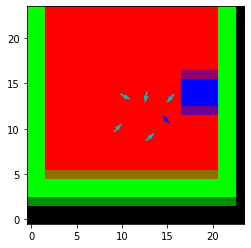

Fit ellipse for group (N=5)


../genff/opt_method/opt_generator.py:167: OptimizeWarning: Initial guess is not within the specified bounds
  res = optimize.minimize(loss, [x0[i, 0], x0[i, 1]], method='Powell', bounds=bnds)


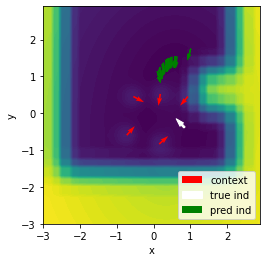

Best result
CircFit: 1.7550505279667206e-07
NotFree: 0.0
PersonalSpace: 0
IntimateSpace: 0
CenterDist: 0.43738256847112594
OccludesOther: 0.0
IsOccluded: 1.0


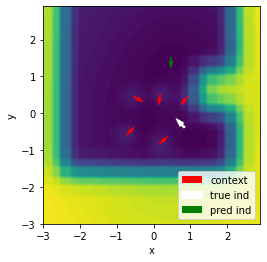

In [7]:
new_individual = new_data_handling(cocktail_skip3, 54, draw_result=True)

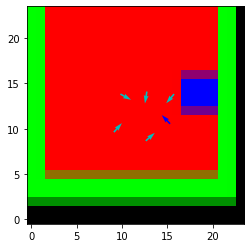

Fit ellipse for group (N=5)


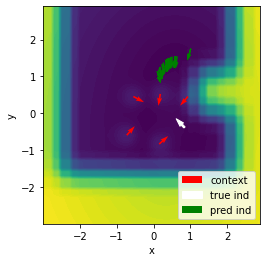

Best result
CircFit: 2.9725787737265323e-07
NotFree: 0.0
PersonalSpace: 0
IntimateSpace: 0
CenterDist: 0.4373922481114321
OccludesOther: 0.0
IsOccluded: 1.0


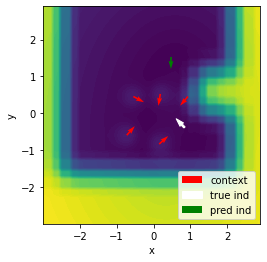

In [8]:
old_individual = old_data_handling(cocktail_skip3_old, 54, draw_result=True)

In [9]:
# metric could be any of {CircFit, NotFree, PerSpace, IntSpace, CenterDist, OccludesOther, IsOccluded}
metric_tag = 'PerSpace'
# compare_results_csv(backup_results_filename, new_results_filename, metric_tag)
diff_deque = compare_results_csv('rule_based_eval/backup/results_040.csv', 'rule_based_eval/20210316_214214/results_040.csv', metric_tag)

for comparison in diff_deque:
    print(f'Index: {comparison[0]}, Old {metric_tag} {comparison[1]}, New {metric_tag} {comparison[2]}')

Index: 31, Old PerSpace 1.0, New PerSpace 2.0
Index: 37, Old PerSpace 0.0, New PerSpace 2.0
Index: 40, Old PerSpace 2.0, New PerSpace 1.0
Index: 41, Old PerSpace 2.0, New PerSpace 1.0
Index: 43, Old PerSpace 0.0, New PerSpace 1.0
Index: 44, Old PerSpace 2.0, New PerSpace 0.0
Index: 48, Old PerSpace 0.0, New PerSpace 1.0
Index: 51, Old PerSpace 1.0, New PerSpace 0.0
Index: 58, Old PerSpace 1.0, New PerSpace 2.0
Index: 61, Old PerSpace 2.0, New PerSpace 1.0
Index: 63, Old PerSpace 1.0, New PerSpace 0.0
Index: 75, Old PerSpace 0.0, New PerSpace 1.0
Index: 79, Old PerSpace 1.0, New PerSpace 0.0
Index: 81, Old PerSpace 2.0, New PerSpace 0.0
Index: 83, Old PerSpace 1.0, New PerSpace 0.0
Index: 88, Old PerSpace 2.0, New PerSpace 1.0
Index: 95, Old PerSpace 2.0, New PerSpace 1.0
Index: 100, Old PerSpace 0.0, New PerSpace 2.0
Index: 121, Old PerSpace 2.0, New PerSpace 1.0
Index: 126, Old PerSpace 2.0, New PerSpace 0.0
Index: 128, Old PerSpace 0.0, New PerSpace 1.0
Index: 131, Old PerSpace 2.0, 